Ce travail met en place une régression logistique bayésienne complète pour détecter les défauts sur les systèmes HVAC à partir de données capteurs. Bien que la chaîne d’apprentissage et d’évaluation soit correcte et la probabilité prédite avec incertitude soit accessible, les résultats sont faibles en termes de rappel et F1-score. Cela s’explique par la simplicité du modèle et la faible diversité de données d’entraînement. Ce premier modèle valide le cadre probabiliste mais doit être enrichi avec des architectures plus puissantes et des données plus variées pour devenir un détecteur fiable généralisable.

In [76]:
import pandas as pd

# 1.1 Chargement du fichier
file_path = r"C:\Users\ADMIN\Desktop\Data Sets for AFDD Evauluation of Building FDD Algorithms\MZVAV-1.csv"
df = pd.read_csv(file_path)

# 1.2 Conversion de la colonne de temps
df['Datetime'] = pd.to_datetime(df['Datetime'])

# 1.3 Filtrage sur les deux jours : 5 et 6 février 2017
start_date = pd.to_datetime("2017-02-04")
end_date = pd.to_datetime("2017-02-07 23:59:59")
df_filtered = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].copy()

# Réinitialisation de l'index (optionnelle mais pratique)
df_filtered.reset_index(drop=True, inplace=True)

# Aperçu du résultat
print(df_filtered['Datetime'].min(), "→", df_filtered['Datetime'].max())
print("Nombre de lignes :", len(df_filtered))
df_filtered.head()


2017-02-04 00:00:00 → 2017-02-07 23:59:00
Nombre de lignes : 5760


,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
0,2017-02-04 00:00:00,51.96,55.04,39.92,60.66,67.14,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
1,2017-02-04 00:01:00,51.96,55.04,39.92,60.66,67.13,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
2,2017-02-04 00:02:00,51.96,55.04,39.90,60.66,67.11,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
3,2017-02-04 00:03:00,51.96,55.04,39.89,60.66,67.09,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
4,2017-02-04 00:04:00,51.96,55.04,39.87,60.66,67.07,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0


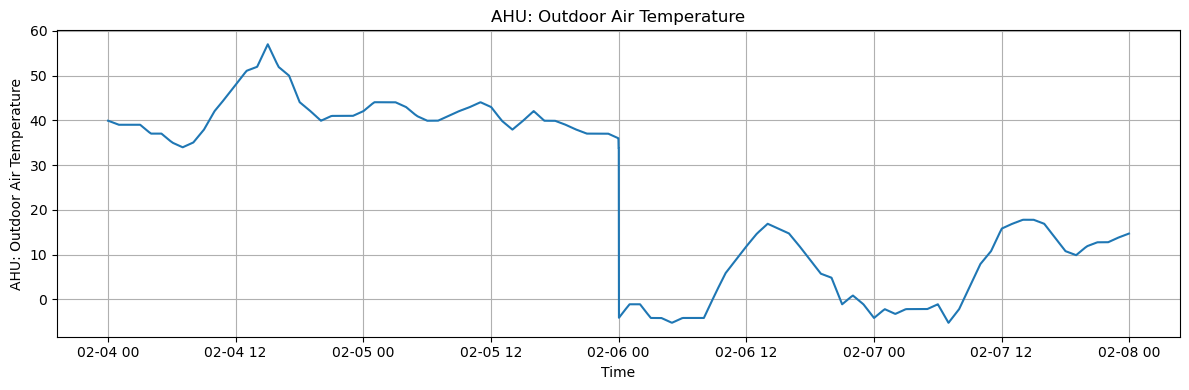

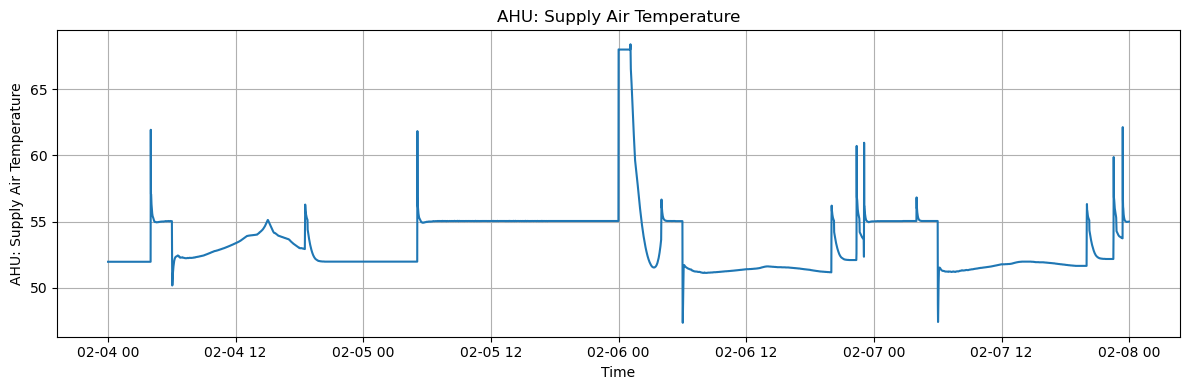

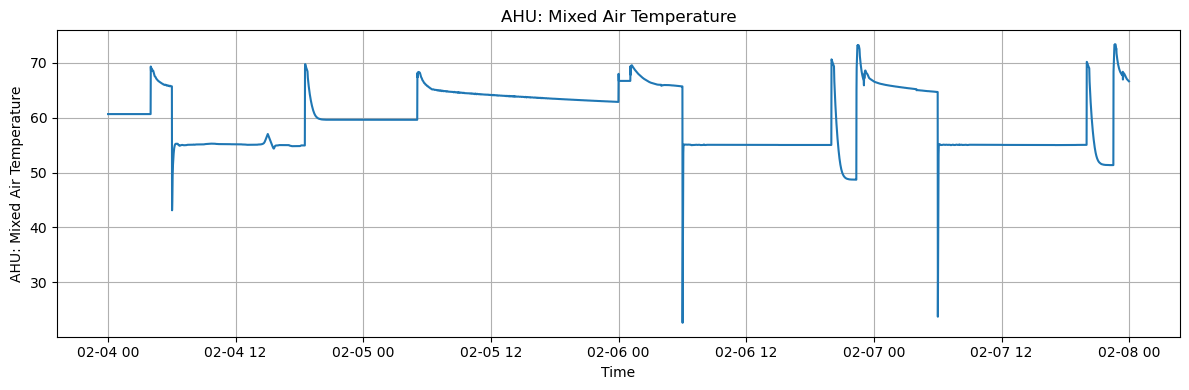

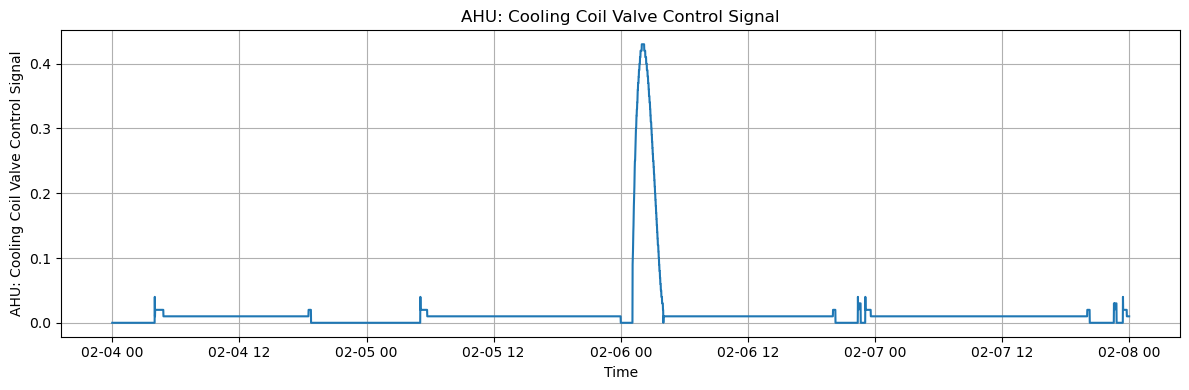

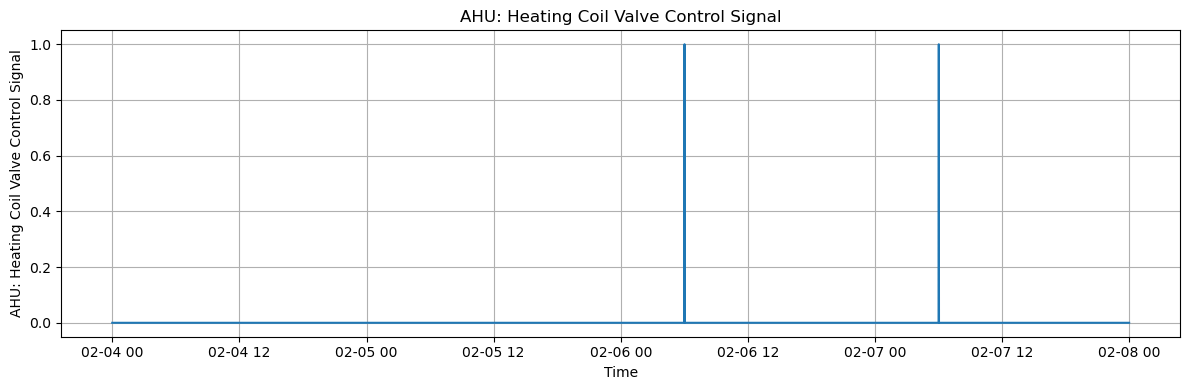

In [77]:
import matplotlib.pyplot as plt

# Définir l'axe x = temps
time = df_filtered['Datetime']

# Liste de colonnes à tracer: Le défaut de ce jour(6 et 7 février 2017consiste à falsifier la valeur du capteur de température extérieure, donc jai 
# choisi les variables les plus pertinentes pour l'analyse de ce défaut
variables = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

# Tracer chaque variable
for var in variables:
    plt.figure(figsize=(12, 4))
    plt.plot(time, df_filtered[var])
    plt.title(var)
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [78]:
# 1. Nettoyage : supprimer les espaces en fin de nom
df_filtered.columns = df_filtered.columns.str.strip()

# 2. Sélection des colonnes utiles
selected_columns = [
    'Datetime',
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

df_filtered = df_filtered[selected_columns].copy()

In [79]:
def determine_fault(date):
    if date in [pd.to_datetime("2017-02-04").date(), pd.to_datetime("2017-02-05").date()]:
        return 0  # normal
    else:
        return 1  # défaut sur 6 

df_filtered['z_t'] = df_filtered['Datetime'].dt.date.apply(determine_fault)


In [80]:
from sklearn.preprocessing import StandardScaler

# 4.1 Extraction des colonnes features (capteurs)
feature_columns = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

X = df_filtered[feature_columns].values

# Standardisation (centrer-réduire)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.2 Extraction de la cible
y = df_filtered['z_t'].values


In [81]:
import pymc as pm
import numpy as np

# Vérifie la forme
n_obs, n_features = X_scaled.shape

with pm.Model() as logistic_model:
    # Priors : # w et b sont les paramètres du modèle logistique
    w = pm.Normal("w", mu=0, sigma=5, shape=n_features) # w cest un Vecteur de poids
    b = pm.Normal("b", mu=0, sigma=5) # b est un scalaire (biais) 
    # w et b sont les paramètres du modèle logistique

    # Calcul de la proba : π_t = sigmoid(w·x_t + b)
    # où x_t est le vecteur de caractéristiques à l'instant t (les observations)
    eta = pm.math.dot(X_scaled, w) + b # eta est lscore brut avant la transformation
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta))  # pi est la probabilité de defaut à l'instant t

    # Likelihood 
    z = pm.Bernoulli("z", p=pi, observed=y) # z est la variable binaire observée (0 ou 1)

    # Échantillonnage MCMC
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 233 seconds.


In [82]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Extraire les échantillons postérieurs de pi
pi_samples = trace.posterior["pi"].stack(samples=("chain", "draw")).values 

# Moyenne et intervalle de crédibilité (95%) pour chaque minute
pi_mean = pi_samples.mean(axis=1) 
pi_hpd = az.hdi(pi_samples.T, hdi_prob=0.95)  # shape: (n_obs, 2)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16020\3774978155.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pi_hpd = az.hdi(pi_samples.T, hdi_prob=0.95)  # shape: (n_obs, 2)


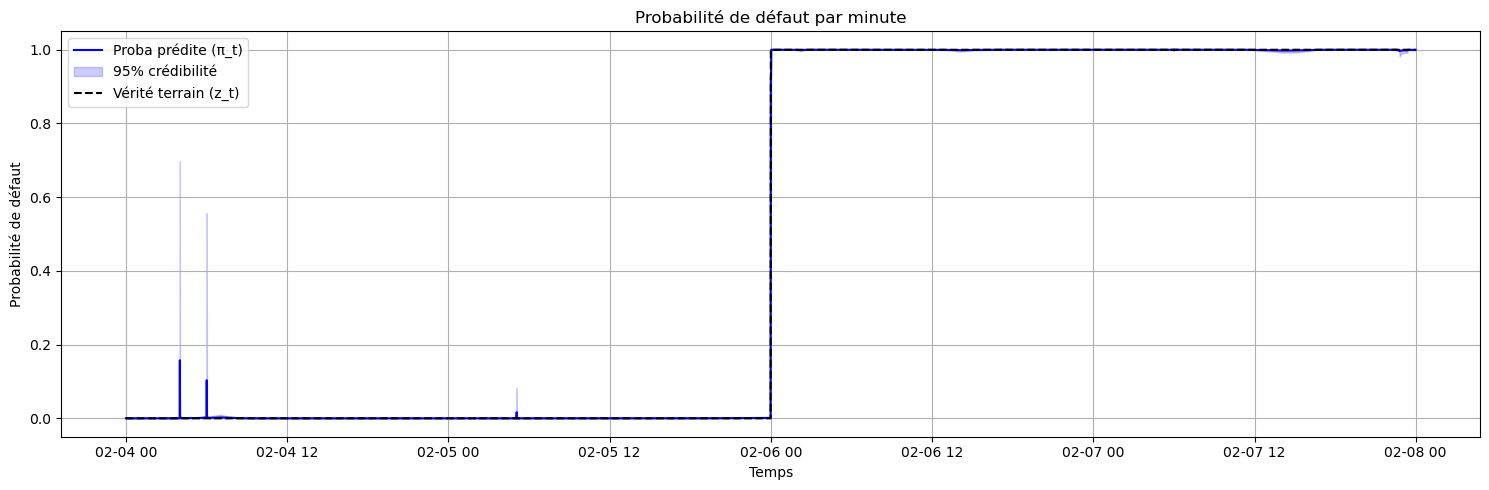

In [83]:
time = df_filtered["Datetime"]
z_true = y  # z_t réels

plt.figure(figsize=(15, 5))
plt.plot(time, pi_mean, label="Proba prédite (π_t)", color='blue')
plt.fill_between(time, pi_hpd[:, 0], pi_hpd[:, 1], color='blue', alpha=0.2, label="95% crédibilité")
plt.plot(time, z_true, label="Vérité terrain (z_t)", color='black', linestyle='--')
plt.title("Probabilité de défaut par minute")
plt.xlabel("Temps")
plt.ylabel("Probabilité de défaut")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
# Extraire les poids
w_samples = trace.posterior["w"].stack(samples=("chain", "draw")).values

# Moyenne et intervalle de crédibilité
w_mean = w_samples.mean(axis=1)
w_hpd = az.hdi(w_samples.T, hdi_prob=0.95)

# Noms des capteurs utilisés (dans l’ordre)
features = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

# Affichage texte
for i, name in enumerate(features):
    print(f"{name:<40}  w_mean = {w_mean[i]: .3f}, 95% CI = [{w_hpd[i,0]:.3f}, {w_hpd[i,1]:.3f}]")


AHU: Outdoor Air Temperature              w_mean = -17.084, 95% CI = [-21.651, -12.689]
AHU: Supply Air Temperature               w_mean =  2.344, 95% CI = [0.733, 4.122]
AHU: Mixed Air Temperature                w_mean = -1.142, 95% CI = [-3.391, 1.280]
AHU: Cooling Coil Valve Control Signal    w_mean =  0.773, 95% CI = [-3.107, 5.778]
AHU: Heating Coil Valve Control Signal    w_mean =  3.650, 95% CI = [-0.580, 10.025]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16020\2820968289.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  w_hpd = az.hdi(w_samples.T, hdi_prob=0.95)


In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prédiction binaire : ẑ_t = 1 si π_t ≥ 0.5
z_pred = (pi_mean >= 0.5).astype(int)

# Comparaison avec les vraies valeurs z_t
print("Taux de bonne classification :", accuracy_score(y, z_pred))


Taux de bonne classification : 1.0


In [86]:
# Calcul des métriques standard
precision = precision_score(y, z_pred)
recall = recall_score(y, z_pred)
f1 = f1_score(y, z_pred)
cm = confusion_matrix(y, z_pred)

print(f"Précision : {precision:.3f}")
print(f"Rappel    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("Matrice de confusion :")
print(cm)


Précision : 1.000
Rappel    : 1.000
F1-score  : 1.000
Matrice de confusion :
[[2880    0]
 [   0 2880]]


In [87]:
import pandas as pd

# Charger le fichier complet si pas déjà en mémoire
df_all = pd.read_csv(file_path)  # file_path = chemin complet de ton fichier MZVAV-1.csv
df_all.columns = df_all.columns.str.strip()  # Nettoyage des noms de colonnes
df_all['Datetime'] = pd.to_datetime(df_all['Datetime'])

# Filtrer les 3 jours cibles
start_date = pd.to_datetime("2017-11-01")
end_date = pd.to_datetime("2017-11-15 23:59:59")
df_nov = df_all[(df_all['Datetime'] >= start_date) & (df_all['Datetime'] <= end_date)].copy()
df_nov.reset_index(drop=True, inplace=True)

# Sélectionner les mêmes colonnes capteurs qu’avant
feature_columns = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

# Extraire X_t
X_nov = df_nov[feature_columns].values

# Standardiser avec le **même scaler que précédemment entraîné**
X_nov_scaled = scaler.transform(X_nov)  # ATTENTION : ne pas refaire fit_transform, juste transform

# Extraire la vérité terrain (z_t) mais ne pas l’utiliser maintenant
z_nov = df_nov['Fault Detection Ground Truth'].values

# Sauvegarder le temps pour l'affichage
time_nov = df_nov['Datetime']


In [88]:
import numpy as np

# Extraire les valeurs postérieures moyennes de w et b depuis le trace existant
# (modèle entraîné sur 5–6 février)
w_post_mean = trace.posterior["w"].stack(samples=("chain", "draw")).mean(axis=1).values
b_post_mean = trace.posterior["b"].stack(samples=("chain", "draw")).mean().values

# Calcul de η_t = wᵀ·x_t + b
eta_nov = np.dot(X_nov_scaled, w_post_mean) + b_post_mean

# Calcul de π_t = sigmoid(η_t)
pi_nov = 1 / (1 + np.exp(-eta_nov))


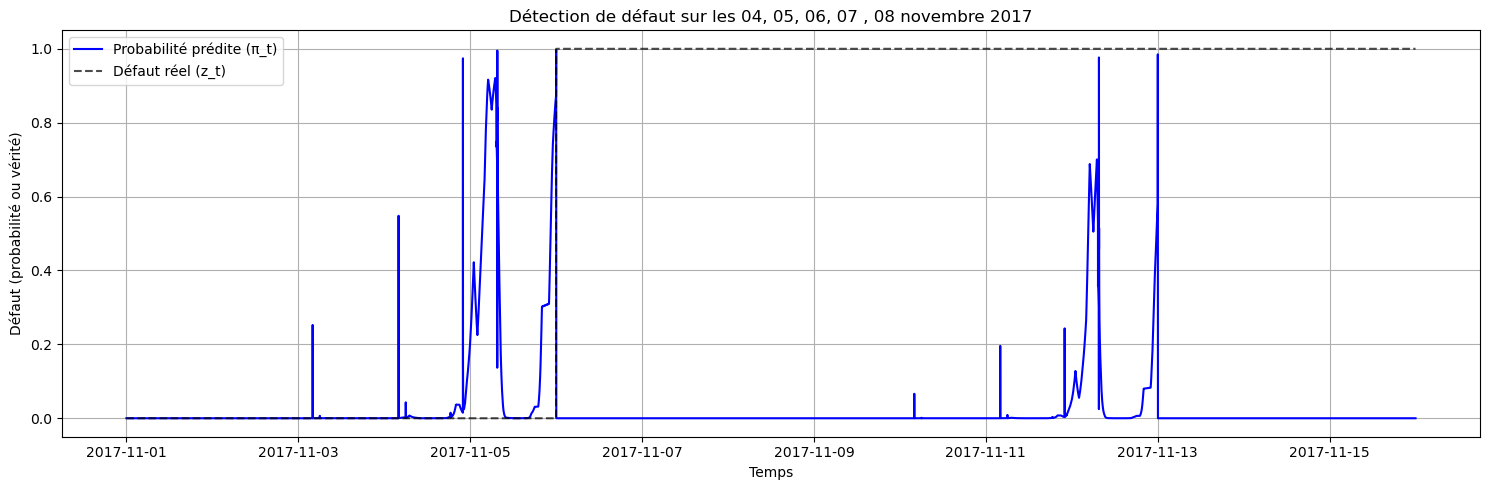

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Courbe bleue : probabilité prédite par le modèle
plt.plot(time_nov, pi_nov, label="Probabilité prédite (π_t)", color="blue")

# Courbe noire pointillée : vérité terrain binaire (z_t)
plt.plot(time_nov, z_nov, label="Défaut réel (z_t)", linestyle="--", color="black", alpha=0.7)

plt.title("Détection de défaut sur les 04, 05, 06, 07 , 08 novembre 2017")
plt.xlabel("Temps")
plt.ylabel("Défaut (probabilité ou vérité)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Appliquer un seuil pour convertir les probabilités π_t en prédiction binaire
z_pred_nov = (pi_nov >= 0.5).astype(int)
# Comparaison avec la vérité z_nov
acc = accuracy_score(z_nov, z_pred_nov)
prec = precision_score(z_nov, z_pred_nov)
rec = recall_score(z_nov, z_pred_nov)
f1 = f1_score(z_nov, z_pred_nov)

# Affichage
print("📊 Évaluation sur 10–12 novembre 2017")
print(f"Accuracy   : {acc:.3f}")
print(f"Précision  : {prec:.3f}")
print(f"Rappel     : {rec:.3f}")
print(f"F1-score   : {f1:.3f}")


📊 Évaluation sur 10–12 novembre 2017
Accuracy   : 0.325
Précision  : 0.338
Rappel     : 0.013
F1-score   : 0.025
